In [6]:
# Cell 1 — imports & options
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.options.future.infer_string = True

In [7]:
def simple_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

def enforce_nonnegative(df: pd.DataFrame) -> pd.DataFrame:
    """Clip logical non-negative numerics at 0 (defensive net)."""
    nonneg = [
        'Lot Area','Lot Frontage','Gr Liv Area',
        'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
        'Garage Area','Garage Cars','1st Flr SF','2nd Flr SF','Low Qual Fin SF',
        'Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch',
        'Pool Area','SalePrice'
    ]
    for c in nonneg:
        if c in df.columns:
            df[c] = df[c].clip(lower=0)
    return df

def normalize_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Trim/standardize string categories (avoids hidden ‘NaN ’, ‘ y ’, etc.)."""
    obj_cols = df.select_dtypes(include='object').columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
        df.loc[df[c].isin(['', 'nan', 'None', 'NaT']), c] = np.nan
    # Central Air should be Y/N
    if 'Central Air' in df.columns:
        df['Central Air'] = df['Central Air'].replace({'Yes': 'Y', 'No': 'N', 'y': 'Y', 'n': 'N'})
    return df

def apply_absence_labels(df: pd.DataFrame) -> pd.DataFrame:
    na_none_map = {
        'Alley': 'NoAlley',
        'Bsmt Qual': 'NoBasement','Bsmt Cond': 'NoBasement','Bsmt Exposure': 'NoBasement',
        'BsmtFin Type 1': 'NoBasement','BsmtFin Type 2': 'NoBasement',
        'Fireplace Qu': 'NoFireplace',
        'Garage Type': 'NoGarage','Garage Finish': 'NoGarage','Garage Qual': 'NoGarage','Garage Cond': 'NoGarage',
        'Pool QC': 'NoPool','Fence': 'NoFence','Misc Feature': 'NoFeature'
    }
    for col, val in na_none_map.items():
        if col in df.columns:
            df[col] = df[col].replace('NA', val).fillna(val)
    return df

def fix_basement_consistency(df: pd.DataFrame) -> pd.DataFrame:
    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    has_bsmt_area = (df[parts].fillna(0).sum(axis=1) > 0)
    bad_expo = has_bsmt_area & (df['Bsmt Exposure'] == 'NoBasement')
    df['Fix_BsmtExposure'] = 0
    df.loc[bad_expo, 'Bsmt Exposure'] = 'No'
    df.loc[bad_expo, 'Fix_BsmtExposure'] = 1

    sum_parts = df[parts].fillna(0).sum(axis=1)
    all_parts_na = df[parts].isna().all(axis=1)
    total_na = df[total].isna()

    mask_true_mismatch = (~all_parts_na) & (~total_na) & (df[total] != sum_parts)
    mask_total_missing = (~all_parts_na) & total_na
    df.loc[mask_true_mismatch, total] = sum_parts[mask_true_mismatch]
    df.loc[mask_total_missing, total] = sum_parts[mask_total_missing]

    mask_parts_missing = all_parts_na & (~total_na)
    for c in parts:
        df.loc[mask_parts_missing, c] = df.loc[mask_parts_missing, c].fillna(0)

    mask_all_missing = all_parts_na & total_na & (df['Bsmt Qual'] == 'NoBasement')
    for c in parts + [total]:
        df.loc[mask_all_missing, c] = 0
    return df

def consolidate_garage_absence(df: pd.DataFrame) -> pd.DataFrame:
    """If no garage (type/area/cars imply absence), zero numerics + set labels to NoGarage."""
    g_zero = (df.get('Garage Cars', 0).fillna(0) == 0) & (df.get('Garage Area', 0).fillna(0) == 0)
    if 'Garage Type' in df.columns:
        g_abs = (df['Garage Type'] == 'NoGarage') | g_zero
        for c in ['Garage Finish','Garage Qual','Garage Cond','Garage Type']:
            if c in df.columns:
                df.loc[g_abs, c] = 'NoGarage'
        for c in ['Garage Yr Blt','Garage Area','Garage Cars']:
            if c in df.columns:
                df.loc[g_abs, c] = 0
    return df

def apply_time_filters(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['Yr Sold'] >= df['Year Built']) & (df['Yr Sold'] >= df['Year Remod/Add'])].copy()
    df = df[df['Year Remod/Add'] >= df['Year Built']].copy()
    mask_gyear_ok = (~df['Garage Yr Blt'].notna()) | (
        (df['Garage Yr Blt'] >= 1880) & (df['Garage Yr Blt'] <= (df['Yr Sold'] + 1))
    )
    return df[mask_gyear_ok].copy()

def add_binary_flags(df: pd.DataFrame) -> pd.DataFrame:
    df['HasPool']   = (df['Pool Area'] > 0).astype(int)
    df['HasFire']   = (df['Fireplaces'] > 0).astype(int)
    df['HasAC']     = (df['Central Air'] == 'Y').astype(int)
    df['HasFence']  = (df['Fence'] != 'NoFence').astype(int)
    df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)
    df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)
    return df

def drop_low_signal_columns(df: pd.DataFrame) -> pd.DataFrame:
    to_drop = ['Utilities','Street','Condition 2','Roof Matl','Heating','Pool QC','Misc Feature','Garage Cond']
    keep = [c for c in to_drop if c in df.columns]
    return df.drop(columns=keep).copy()

def ordinal_encode_inplace(df: pd.DataFrame) -> pd.DataFrame:
    ord_orders = {
        'Exter Qual':['Po','Fa','TA','Gd','Ex'],'Exter Cond':['Po','Fa','TA','Gd','Ex'],
        'Bsmt Qual':['NoBasement','Po','Fa','TA','Gd','Ex'],'Bsmt Cond':['NoBasement','Po','Fa','TA','Gd','Ex'],
        'Bsmt Exposure':['NoBasement','No','Mn','Av','Gd'],
        'BsmtFin Type 1':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'BsmtFin Type 2':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'Heating QC':['Po','Fa','TA','Gd','Ex'],'Electrical':['FuseP','FuseF','Mix','FuseA','SBrkr'],
        'Kitchen Qual':['Po','Fa','TA','Gd','Ex'],'Fireplace Qu':['NoFireplace','Po','Fa','TA','Gd','Ex'],
        'Garage Finish':['NoGarage','Unf','RFn','Fin'],'Garage Qual':['NoGarage','Po','Fa','TA','Gd','Ex'],
        'Paved Drive':['N','P','Y'],'Lot Shape':['IR3','IR2','IR1','Reg'],'Land Slope':['Sev','Mod','Gtl'],
    }
    for col, order in ord_orders.items():
        if col in df.columns:
            cat = pd.Categorical(df[col], categories=order, ordered=True)
            s = pd.Series(cat.codes, index=df.index).astype('float64')
            s[s == -1] = np.nan
            df[col] = s
    return df

def bucket_rare(df: pd.DataFrame, cols: list, min_count: int = 5) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            vc = df[c].value_counts(dropna=False)
            rare = set(vc[vc < min_count].index)
            df[c] = df[c].where(~df[c].isin(rare), "__Other__")
    return df


In [8]:
def compute_train_stats(df_tr: pd.DataFrame):
    stats = {}
    if 'Lot Frontage' in df_tr.columns and 'Neighborhood' in df_tr.columns:
        stats['lf_med_nb']   = df_tr.groupby('Neighborhood')['Lot Frontage'].median()
        stats['lf_med_glob'] = df_tr['Lot Frontage'].median()
    else:
        stats['lf_med_nb'] = pd.Series(dtype='float64'); stats['lf_med_glob'] = np.nan

    label_cols_all = ['Garage Finish','Garage Qual','Garage Cond']
    label_cols = [c for c in label_cols_all if c in df_tr.columns]
    g_has_tr = (
        (df_tr.get('Garage Type', 'NoGarage') != 'NoGarage') |
        (df_tr.get('Garage Area', pd.Series(0, index=df_tr.index)).fillna(0) > 0) |
        (df_tr.get('Garage Cars', pd.Series(0, index=df_tr.index)).fillna(0) > 0)
    )
    if 'Garage Type' in df_tr.columns and any(label_cols):
        try:
            stats['g_modes_by_type'] = df_tr[g_has_tr].groupby('Garage Type')[label_cols].agg(simple_mode)
        except Exception:
            stats['g_modes_by_type'] = pd.DataFrame()
    else:
        stats['g_modes_by_type'] = pd.DataFrame()

    stats['g_med_area_by_type'] = (df_tr[g_has_tr].groupby('Garage Type')['Garage Area'].median()
                                   if {'Garage Type','Garage Area'} <= set(df_tr.columns) else pd.Series(dtype='float64'))
    stats['g_med_cars_by_type'] = (df_tr[g_has_tr].groupby('Garage Type')['Garage Cars'].median()
                                   if {'Garage Type','Garage Cars'} <= set(df_tr.columns) else pd.Series(dtype='float64'))

    if {'Mas Vnr Area','Mas Vnr Type'} <= set(df_tr.columns):
        ref = df_tr[(df_tr['Mas Vnr Area'].fillna(0) > 0) & df_tr['Mas Vnr Type'].notna() & (df_tr['Mas Vnr Type'] != 'None')]
        stats['mvt_nb_mode'] = (ref.groupby('Neighborhood')['Mas Vnr Type'].agg(simple_mode)
                                if 'Neighborhood' in df_tr.columns else pd.Series(dtype='object'))
        gmode = df_tr['Mas Vnr Type'].dropna().mode()
        stats['mvt_global_mode'] = gmode.iloc[0] if len(gmode) else 'BrkFace'
    else:
        stats['mvt_nb_mode'] = pd.Series(dtype='object'); stats['mvt_global_mode'] = 'BrkFace'

    num_cols = [c for c in df_tr.select_dtypes(include=[np.number]).columns if c != 'SalePrice']
    stats['num_medians'] = df_tr[num_cols].median(numeric_only=True)
    return stats

def apply_train_stats(df_block: pd.DataFrame, stats: dict) -> pd.DataFrame:
    if {'Lot Frontage','Neighborhood'} <= set(df_block.columns) and not pd.isna(stats.get('lf_med_glob', np.nan)):
        df_block['Lot Frontage'] = df_block['Lot Frontage'].fillna(df_block['Neighborhood'].map(stats['lf_med_nb'])).fillna(stats['lf_med_glob'])

    g_has = (
        (df_block.get('Garage Type', 'NoGarage') != 'NoGarage') |
        (df_block.get('Garage Area', pd.Series(0, index=df_block.index)).fillna(0) > 0) |
        (df_block.get('Garage Cars', pd.Series(0, index=df_block.index)).fillna(0) > 0)
    )
    if isinstance(stats.get('g_modes_by_type'), pd.DataFrame) and not stats['g_modes_by_type'].empty and 'Garage Type' in df_block.columns:
        need_fix = g_has & (
            (df_block.get('Garage Finish', pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Qual',   pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Cond',   pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Finish', pd.Series('NoGarage', index=df_block.index)) == 'NoGarage') |
            (df_block.get('Garage Qual',   pd.Series('NoGarage', index=df_block.index)) == 'NoGarage') |
            (df_block.get('Garage Cond',   pd.Series('NoGarage', index=df_block.index)) == 'NoGarage')
        )
        for c in ['Garage Finish','Garage Qual','Garage Cond']:
            if c in df_block.columns and c in stats['g_modes_by_type'].columns:
                fill_vals = df_block.loc[need_fix, 'Garage Type'].map(stats['g_modes_by_type'][c])
                df_block.loc[need_fix, c] = df_block.loc[need_fix, c].fillna(fill_vals)

    if {'Garage Area','Garage Type'} <= set(df_block.columns) and not stats.get('g_med_area_by_type', pd.Series()).empty:
        m_area_na = g_has & df_block['Garage Area'].isna()
        df_block.loc[m_area_na, 'Garage Area'] = df_block.loc[m_area_na, 'Garage Type'].map(stats['g_med_area_by_type'])
    if {'Garage Cars','Garage Type'} <= set(df_block.columns) and not stats.get('g_med_cars_by_type', pd.Series()).empty:
        m_cars_na = g_has & df_block['Garage Cars'].isna()
        df_block.loc[m_cars_na, 'Garage Cars'] = df_block.loc[m_cars_na, 'Garage Type'].map(stats['g_med_cars_by_type'])

    if {'Mas Vnr Area','Mas Vnr Type'} <= set(df_block.columns):
        area = df_block['Mas Vnr Area']; typ = df_block['Mas Vnr Type']
        m_area0 = area.fillna(0) == 0; m_area_pos = area.fillna(0) > 0
        m_type_none = typ == 'None'; m_type_na = typ.isna()
        df_block.loc[m_type_na & m_area0, 'Mas Vnr Type'] = 'None'
        df_block.loc[(~m_type_none & ~m_type_na) & m_area0, 'Mas Vnr Type'] = 'None'
        mask_pos_missing = m_area_pos & (m_type_none | m_type_na)
        nb_mode = stats.get('mvt_nb_mode', pd.Series(dtype='object')); global_mode = stats.get('mvt_global_mode', 'BrkFace')
        if not nb_mode.empty and 'Neighborhood' in df_block.columns:
            nb_fill = df_block.loc[mask_pos_missing, 'Neighborhood'].map(nb_mode).fillna(global_mode)
        else:
            nb_fill = pd.Series(global_mode, index=df_block.index).loc[mask_pos_missing]
        df_block.loc[mask_pos_missing, 'Mas Vnr Type'] = nb_fill
    return df_block

def fill_not_present_numerics(df_block: pd.DataFrame) -> pd.DataFrame:
    exist_num = ['Garage Yr Blt','Garage Area','Garage Cars',
                 'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
                 'Bsmt Full Bath','Bsmt Half Bath','Pool Area','Mas Vnr Area']
    for c in exist_num:
        if c in df_block.columns:
            df_block[f'{c}_was_missing'] = df_block[c].isna().astype(int)
            df_block[c] = df_block[c].fillna(0)
    return df_block

def fill_remaining_numerics_with_train_median(df_block: pd.DataFrame, num_medians: pd.Series) -> pd.DataFrame:
    for c in df_block.select_dtypes(include=[np.number]).columns:
        if df_block[c].isna().any():
            df_block[c] = df_block[c].fillna(num_medians.get(c, df_block[c].median()))
    return df_block

In [9]:
def generate_sanity_report(df_raw, df_train_clean, df_test_clean, meta, make_plots=True):
    df_clean_all = pd.concat([df_train_clean, df_test_clean], ignore_index=True)
    n_raw = meta.get('n_raw', len(df_raw)); n_after_time = meta.get('n_after_time', len(df_clean_all))
    dropped_time = n_raw - n_after_time; pct_dropped = (dropped_time / n_raw) * 100 if n_raw else 0
    print("=== Sanity report ===")
    print(f"- Rows initiale: {n_raw}")
    print(f"- După filtre temporale: {n_after_time}  (drop: {dropped_time} | {pct_dropped:.2f}%)")
    n_fix_bsmt = meta.get('n_fix_bsmt_exposure', int(df_clean_all.get('Fix_BsmtExposure', pd.Series(0)).sum()))
    print(f"- Corecții Bsmt Exposure (NoBasement -> No când există arii): {n_fix_bsmt}")

    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    if all(c in df_clean_all.columns for c in parts+[total]):
        mismatch = (df_clean_all[total] != df_clean_all[parts].fillna(0).sum(axis=1)).sum()
        print(f"- Identități subsol (Total == sum(parts)) → mismatches: {mismatch}")
    else:
        print("- Identități subsol: coloane lipsă, skip.")

    na_raw = df_raw.isna().sum().sort_values(ascending=False)
    na_clean = df_clean_all.isna().sum().sort_values(ascending=False)
    print("\nTop 10 coloane cu NaN (înainte):"); print(na_raw.head(10))
    print("\nTop 10 coloane cu NaN (după curățare):"); print(na_clean.head(10))
    print(f"\nShapes: train={df_train_clean.shape}, test={df_test_clean.shape}")
    if 'SalePrice' in df_raw.columns:
        sp_raw = df_raw['SalePrice'].dropna(); sp_clean = df_clean_all['SalePrice'].dropna()
        print(f"SalePrice (raw):   n={sp_raw.size}, min={sp_raw.min():,.0f}, median={sp_raw.median():,.0f}, max={sp_raw.max():,.0f}")
        print(f"SalePrice (clean): n={sp_clean.size}, min={sp_clean.min():,.0f}, median={sp_clean.median():,.0f}, max={sp_clean.max():,.0f}")

    if make_plots:
        try: plot_sanity(df_raw, df_clean_all)
        except Exception as e: print(f"(plot warning) {e}")

def plot_sanity(df_raw, df_clean):
    if 'SalePrice' in df_raw.columns and 'SalePrice' in df_clean.columns:
        plt.figure(figsize=(7,4))
        plt.hist(df_raw['SalePrice'].dropna(), bins=50, alpha=0.35, label='raw')
        plt.hist(df_clean['SalePrice'].dropna(), bins=50, alpha=0.6, label='clean')
        plt.title("SalePrice: raw vs clean (hist)"); plt.xlabel("SalePrice"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()
    if all(c in df_clean.columns for c in ['Gr Liv Area','SalePrice']):
        plt.figure(figsize=(6,4))
        plt.scatter(df_clean['Gr Liv Area'], df_clean['SalePrice'], s=8, alpha=0.5)
        plt.title("SalePrice vs Gr Liv Area (clean)"); plt.xlabel("Gr Liv Area"); plt.ylabel("SalePrice"); plt.tight_layout(); plt.show()

def validate_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Return a small table of issues (row_idx, column, rule, value) without mutating df."""
    issues = []
    def report(mask, col, rule):
        idx = df.index[mask]
        for i in idx:
            issues.append((int(i), col, rule, df.at[i, col] if col in df.columns else None))

    if {'Mo Sold','Yr Sold'} <= set(df.columns):
        report(~df['Mo Sold'].between(1,12), 'Mo Sold', 'month_out_of_range')
        report(~df['Yr Sold'].between(1800, 2100), 'Yr Sold', 'year_out_of_range')

    if {'Overall Qual','Overall Cond'} <= set(df.columns):
        report(~df['Overall Qual'].between(1,10), 'Overall Qual', 'qual_out_of_range')
        report(~df['Overall Cond'].between(1,10), 'Overall Cond', 'cond_out_of_range')

    if {'Year Built','Year Remod/Add'} <= set(df.columns):
        report(df['Year Remod/Add'] < df['Year Built'], 'Year Remod/Add', 'remod_before_built')

    if {'Garage Yr Blt','Yr Sold'} <= set(df.columns):
        gy = df['Garage Yr Blt']; ys = df['Yr Sold']
        report(gy.notna() & (gy < 1880), 'Garage Yr Blt', 'garage_too_old')
        report(gy.notna() & (gy > ys + 1), 'Garage Yr Blt', 'garage_after_sale+1')

    pos_when_present = ['Gr Liv Area','1st Flr SF','SalePrice']
    for c in pos_when_present:
        if c in df.columns:
            report(df[c] < 0, c, 'negative_value')

    return pd.DataFrame(issues, columns=['row_idx','column','rule','value'])


In [10]:
def clean_ames(csv_path: str,
               test_size: float = 0.2,
               random_state: int = 42,
               return_meta: bool = False,
               use_rare_bucket: bool = False,
               winsorize: bool = False,
               drop_exact_duplicates: bool = True,
               drop_audit_flags: bool = True):
    """
    Deterministic, leak-free cleaning. Outlier trimming is OFF by default (see train_band_filter).
    """
    df_raw = pd.read_csv(csv_path, sep="\t")
    meta = {'n_raw': len(df_raw), 'na_raw_top': df_raw.isna().sum().sort_values(ascending=False).head(10)}

    # ---- Safe pre-split steps
    df = df_raw.copy()
    df = normalize_categoricals(df)
    df = apply_absence_labels(df)
    df = fix_basement_consistency(df)
    df = consolidate_garage_absence(df)
    df = enforce_nonnegative(df)

    if drop_exact_duplicates:
        before = len(df); df = df.drop_duplicates().copy(); meta['n_dropped_dupes'] = before - len(df)

    n_before_time = len(df)
    df = apply_time_filters(df)
    meta['n_after_time'] = len(df); meta['n_dropped_time'] = n_before_time - meta['n_after_time']

    df = add_binary_flags(df)
    df = drop_low_signal_columns(df)

    if use_rare_bucket:
        nominal_candidates = ['MS SubClass','MS Zoning','Neighborhood','Condition 1','Bldg Type','House Style',
                              'Roof Style','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Lot Config',
                              'Land Contour','Garage Type','Sale Type','Sale Condition']
        nominal_cols = [c for c in nominal_candidates if c in df.columns]
        df = bucket_rare(df, nominal_cols, min_count=5)

    df = ordinal_encode_inplace(df)

    # Drop IDs
    df = df.drop(columns=['Order','PID'], errors='ignore')

    # ---- Split early (avoid leakage)
    train_idx, test_idx = train_test_split(df.index, test_size=test_size, random_state=random_state)
    df_tr = df.loc[train_idx].copy(); df_te = df.loc[test_idx].copy()

    # ---- Train-only stats, apply to both
    stats = compute_train_stats(df_tr)
    df_tr = apply_train_stats(df_tr, stats); df_te = apply_train_stats(df_te, stats)

    # Not-present numerics → 0 (+indicator)
    df_tr = fill_not_present_numerics(df_tr); df_te = fill_not_present_numerics(df_te)

    # (optional) winsorization — *feature* numerics only (no target)
    if winsorize:
        num_cols_tr = [c for c in df_tr.select_dtypes(include=[np.number]).columns if c != 'SalePrice']
        q_lo = df_tr[num_cols_tr].quantile(0.01); q_hi = df_tr[num_cols_tr].quantile(0.99)
        for c in num_cols_tr:
            df_tr[c] = df_tr[c].clip(lower=q_lo.get(c, df_tr[c].min()), upper=q_hi.get(c, df_tr[c].max()))
            if c in df_te.columns:
                lo = q_lo.get(c, df_tr[c].min()); hi = q_hi.get(c, df_tr[c].max())
                df_te[c] = df_te[c].clip(lower=lo, upper=hi)

    # Remaining numerics → train medians
    df_tr = fill_remaining_numerics_with_train_median(df_tr, stats['num_medians'])
    df_te = fill_remaining_numerics_with_train_median(df_te, stats['num_medians'])

    # Reset index
    df_tr = df_tr.reset_index(drop=True); df_te = df_te.reset_index(drop=True)

    # Meta checks (report needs the flags present)
    meta['n_fix_bsmt_exposure'] = int(df.get('Fix_BsmtExposure', pd.Series(0)).sum())
    all_clean = pd.concat([df_tr, df_te], ignore_index=True)
    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    meta['post_clean_bsmt_mismatch'] = (int((all_clean[total] != all_clean[parts].fillna(0).sum(axis=1)).sum())
                                        if all(c in all_clean.columns for c in parts+[total]) else None)
    meta['na_clean_top'] = all_clean.isna().sum().sort_values(ascending=False).head(10)

    # Validation report (non-fatal)
    meta['validation_issues_train'] = validate_dataset(df_tr).head(15)
    meta['validation_issues_test']  = validate_dataset(df_te).head(15)

    # --- Drop audit flags after meta/report, if requested
    if drop_audit_flags:
        audit_cols = ['Fix_BsmtExposure', 'Fix_Garage']  # Fix_Garage may not exist
        df_tr = df_tr.drop(columns=[c for c in audit_cols if c in df_tr.columns], errors='ignore')
        df_te = df_te.drop(columns=[c for c in audit_cols if c in df_te.columns], errors='ignore')

    if return_meta:
        return df_tr, df_te, meta
    return df_tr, df_te

In [11]:
def train_band_filter(df_tr: pd.DataFrame,
                      x_col: str = 'Gr Liv Area',
                      y_col: str = 'SalePrice',
                      low_q: float = 0.10,
                      high_q: float = 0.90):
    """
    Return a row mask for TRAIN keeping only points within [low_q, high_q]
    conditional quantile band of log(y) ~ log(x). Uses sklearn QuantileRegressor.
    """
    from sklearn.linear_model import QuantileRegressor

    x = np.log1p(df_tr[x_col].clip(lower=0)).values.reshape(-1, 1)
    y = np.log1p(df_tr[y_col].clip(lower=0)).values
    qr_low  = QuantileRegressor(quantile=low_q, alpha=0).fit(x, y)
    qr_high = QuantileRegressor(quantile=high_q, alpha=0).fit(x, y)
    y_pred_lo = qr_low.predict(x); y_pred_hi = qr_high.predict(x)
    keep_mask = (y >= y_pred_lo) & (y <= y_pred_hi)
    return keep_mask


Train 20% shape: (2213, 89) Test 20% shape: (554, 89)
=== Sanity report ===
- Rows initiale: 2930
- După filtre temporale: 2767  (drop: 163 | 5.56%)
- Corecții Bsmt Exposure (NoBasement -> No când există arii): 3
- Identități subsol (Total == sum(parts)) → mismatches: 0

Top 10 coloane cu NaN (înainte):
Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Mas Vnr Type     1775
Fireplace Qu     1422
Lot Frontage      490
Garage Qual       159
Garage Yr Blt     159
Garage Cond       159
dtype: int64

Top 10 coloane cu NaN (după curățare):
MS SubClass     0
MS Zoning       0
Lot Frontage    0
Lot Area        0
Alley           0
Lot Shape       0
Land Contour    0
Lot Config      0
Land Slope      0
Neighborhood    0
dtype: int64

Shapes: train=(2213, 89), test=(554, 89)
SalePrice (raw):   n=2930, min=12,789, median=160,000, max=755,000
SalePrice (clean): n=2767, min=12,789, median=165,000, max=755,000


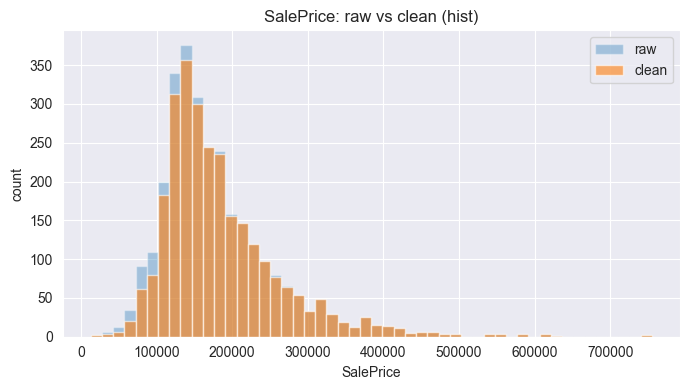

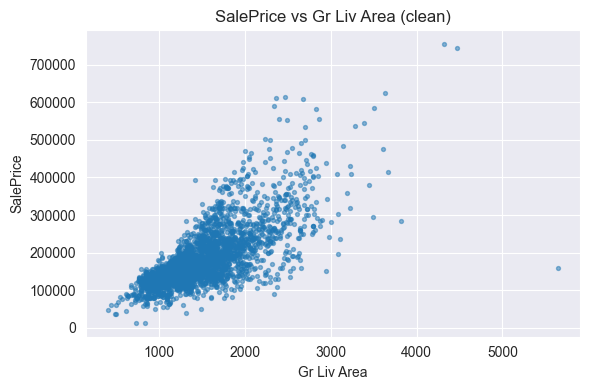

In [12]:
if __name__ == "__main__":
    # Cleaning only (no outlier trimming)
    df_train_20, df_test_20, meta_20 = clean_ames(
        "AmesHousing.csv",
        test_size=0.2,
        random_state=42,
        return_meta=True,
        use_rare_bucket=False,   # stays OFF (safe)
        winsorize=False,         # stays OFF (modeling choice)
        drop_exact_duplicates=True,
        drop_audit_flags=True    # <— recommended ON for modeling
    )
    print("Train 20% shape:", df_train_20.shape, "Test 20% shape:", df_test_20.shape)

    # Report + quick plots
    generate_sanity_report(
        df_raw=pd.read_csv("AmesHousing.csv", sep="\t"),
        df_train_clean=df_train_20,
        df_test_clean=df_test_20,
        meta=meta_20,
        make_plots=True
    )

    # OPTIONAL: TRAIN-ONLY trimming (leak-free)
    # keep_mask = train_band_filter(df_train_20, x_col='Gr Liv Area', y_col='SalePrice', low_q=0.10, high_q=0.90)
    # df_train_band = df_train_20.loc[keep_mask].reset_index(drop=True)
    # print(f"Band-kept rows: {keep_mask.sum()} / {len(keep_mask)} ({keep_mask.mean()*100:.1f}%)")

 Dataset overview

- Raw rows: 2930
- After temporal filters: 2767 rows
  → Dropped 163 rows (5.56%)
  → Reason: impossible chronology (Year Built, Year Remod/Add, Yr Sold, or Garage Yr Blt inconsistent)

- Train/Test split:
  - Train: 2213 rows
  - Test: 554 rows
  - Columns: 89 each

Temporal consistency filters

- Yr Sold ≥ Year Built
- Yr Sold ≥ Year Remod/Add
- Year Remod/Add ≥ Year Built
- Garage Yr Blt between 1880 and Yr Sold + 1

→ 163 rows removed (~5.56%) because they violated at least one rule.

 Basement consistency fixes

- 3 rows corrected where Bsmt Exposure was “NoBasement” but basement area > 0.
  These were changed to “No” and flagged in Fix_BsmtExposure.

- Checked identity:
  Total Bsmt SF == BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF
  → 0 mismatches after cleaning.

 Missing data profile

 Before cleaning (top 10 columns with missing values)

| Column | Missing count |
|:--|--:|
| Pool QC | 2917 |
| Misc Feature | 2824 |
| Alley | 2732 |
| Fence | 2358 |
| Mas Vnr Type | 1775 |
| Fireplace Qu | 1422 |
| Lot Frontage | 490 |
| Garage Qual | 159 |
| Garage Yr Blt | 159 |
| Garage Cond | 159 |

Most missing values correspond to optional features (pools, fences, alleys).
These were replaced with explicit absence labels like “NoPool”, “NoFence”, “NoGarage”, etc.

### After cleaning (top 10 columns with missing values)

| Column | Missing count |
|:--|--:|
| MS SubClass | 0 |
| MS Zoning | 0 |
| Lot Frontage | 0 |
| Lot Area | 0 |
| Alley | 0 |
| Lot Shape | 0 |
| Land Contour | 0 |
| Lot Config | 0 |
| Land Slope | 0 |
| Neighborhood | 0 |

All missing values have been handled.
No remaining NaN values in either numeric or categorical columns.

SalePrice distribution

| Stage | Rows | Median | Min | Max |
|:--|--:|--:|--:|--:|
| Raw | 2930 | 160000 | 12789 | 755000 |
| Cleaned | 2767 | 165000 | 12789 | 755000 |

Median increased slightly after filtering (160k → 165k),
most likely because invalid or inconsistent low-priced entries were removed.

Sanity summary

| Check | Status | Notes |
|:--|:--|:--|
| Temporal logic | OK | 163 invalid rows removed |
| Basement identity | OK | Totals match parts |
| Garage logic | OK | Invalid years and NaNs fixed |
| Missing data | OK | All filled logically |
| Outliers | To do | Will be handled later (train-only quantile band) |
| Leakage | None | Train/test split before computing stats |
| Dataset balance | OK | 80/20 split consistent |

DONE

* TODO Outlier filtering can be applied later using `train_band_filter()` if needed.*